In [52]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import *
from electronfactors.model.threshold import *
from electronfactors.ellipse.utilities import _CustomBasinhopping as optimise

In [53]:
# Set up figure style
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)
rc('legend', fontsize=16)

In [3]:
width, length, eqPonA, factor = pull_data(energy=12)
model = create_model(width, eqPonA, factor)

In [4]:
x = np.arange(2.5, 10, 0.1)
y = np.arange(2.5, 18, 0.1)

mesh_width, mesh_length = np.meshgrid(x, y)

mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

width_length_zz = model(mesh_width, mesh_eqPonA)
give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)


mesh_max_area = ((10 * np.sqrt(2) - mesh_width) * mesh_width + (mesh_width/np.sqrt(2))**2)
mesh_max_length = 4 * mesh_max_area / (np.pi * mesh_width)


invalid = (give > 0.5) | (mesh_width > mesh_length) | (mesh_length > mesh_max_length)

width_length_zz[invalid] = np.nan

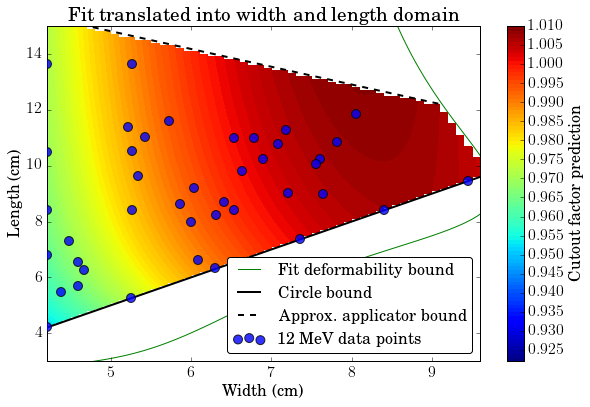

In [5]:
circle_bound_width = np.linspace(np.min(width) - 0.16, np.max(width) + 0.24)

max_length_width = np.linspace(2, 9.1)
max_area = ((10 * np.sqrt(2) - max_length_width) * max_length_width + (max_length_width/np.sqrt(2))**2)
max_length = 4 * max_area / (np.pi * max_length_width)


plt.figure(figsize=(6 * 1.618, 6))
c = plt.contourf(mesh_width, mesh_length ,width_length_zz, 100, alpha=1)
colourbar = plt.colorbar(c, ticks=np.arange(0.90, 1.1, 0.005), label=r'Cutout factor prediction')

plt.scatter(width, length, s=80, alpha=0.8, zorder=3, label=r'12 MeV data points')

plt.contour(mesh_width, mesh_length, give, levels=[0.5], colors='g')
plt.plot(3, 0.4, 'g-', label=r'Fit deformability bound')

plt.plot(circle_bound_width, circle_bound_width, 'k', lw=2, label=r'Circle bound')
plt.plot(max_length_width, max_length, 'k--', lw=2, label=r'Approx. applicator bound')

plt.xlabel(r'Width (cm)')
plt.ylabel(r'Length (cm)')
plt.title(r'Fit translated into width and length domain')
plt.xlim([4.2, 9.6])
plt.ylim([3,15])

# plt.axis("Equal")
legend = plt.legend(fancybox=True, loc='lower right')
legend.get_frame().set_facecolor('white')

In [6]:
a = [1,2,3]
a[-1:]

[3]

In [7]:
percent_prediction_differences = calculate_percent_prediction_differences(width, eqPonA, factor)
prediction_uncertainty = np.std(percent_prediction_differences, ddof=1) / c4(len(percent_prediction_differences))
prediction_uncertainty

0.483268666898374

In [8]:
prediction_give = np.zeros(len(width))

for i in range(len(width)):
    widthTest = np.delete(width, i)
    eqPonATest = np.delete(eqPonA, i)
    factorTest = np.delete(factor, i)

    prediction_give[i] = fit_give(
        width[i], eqPonA[i], widthTest, eqPonATest, factorTest)
    
prediction_give

array([ 0.60675811,  0.23751874,  0.18308769,  0.17151763,  0.06694804,
        0.04759595,  0.13978908,  0.11265016,  0.08526066,  0.04038007,
        0.07145716,  0.059324  ,  0.1129818 ,  0.05749515,  0.07227699,
        0.05161558,  0.11476105,  0.24177763,  0.05465834,  0.0500901 ,
        0.05943731,  0.07135422,  0.18897887,  0.07489636,  0.20858389,
        0.65893914,  0.0393433 ,  0.07103284,  0.0441862 ,  0.06521017,
        0.06453059,  0.25633785,  0.06214904,  0.08977221,  0.06569457,
        0.15650894,  0.06931719,  0.04709734,  0.22386708,  0.09029857,
        0.09942962,  0.24892485,  0.04163476,  0.05564207,  0.07721491,
        0.05175398,  0.05839732,  0.09387881,  0.08764404])

In [9]:
numTrials = 5000

predictions = model(width, eqPonA)
mesh_resampled_predictions = np.zeros(np.shape(mesh_width) + (numTrials,))

for i in range(numTrials):

    resample = np.random.normal(loc=predictions, scale=prediction_uncertainty)
    test_model = create_model(width, eqPonA, resample)

    mesh_resampled_predictions[:, :, i] = test_model(mesh_width, mesh_eqPonA)

In [10]:
mesh_variant_uncertainty_estimate = np.std(mesh_resampled_predictions, ddof=1, axis=2) / c4(numTrials)
mesh_variant_uncertainty_estimate[invalid] = np.nan

../electronfactors/model/utilities.py:119: RuntimeWarning: invalid value encountered in double_scalars
  output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)


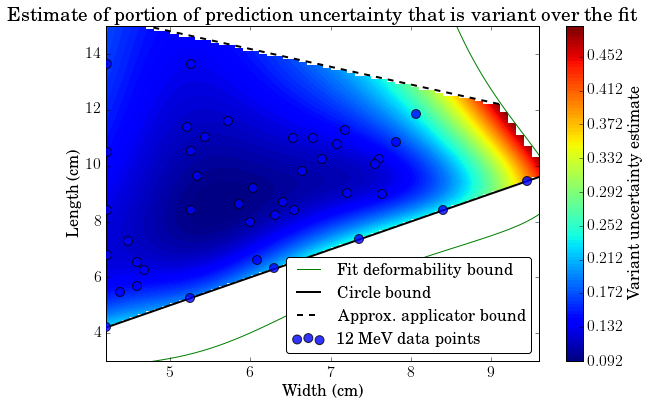

In [11]:
plt.figure(figsize=(6 * 1.618, 6))
c = plt.contourf(mesh_width, mesh_length, mesh_variant_uncertainty_estimate, 100, alpha=1)
colourbar = plt.colorbar(c, label=r'Variant uncertainty estimate')

plt.scatter(width, length, s=80, alpha=0.8, zorder=3, label=r'12 MeV data points')

plt.contour(mesh_width, mesh_length, give, levels=[0.5], colors='g')
plt.plot(3, 0.4, 'g-', label=r'Fit deformability bound')

plt.plot(circle_bound_width, circle_bound_width, 'k', lw=2, label=r'Circle bound')
plt.plot(max_length_width, max_length, 'k--', lw=2, label=r'Approx. applicator bound')

plt.xlabel(r'Width (cm)')
plt.ylabel(r'Length (cm)')
plt.title(r'Estimate of portion of prediction uncertainty that is variant over the fit')
plt.xlim([4.2, 9.6])
plt.ylim([3, 15])

# plt.axis("Equal")
legend = plt.legend(fancybox=True, loc='lower right')
legend.get_frame().set_facecolor('white')

In [12]:
len(percent_prediction_differences)

47

In [13]:
numTrials = 5000

test_reference = prediction_give < 0.5

predictions = model(width, eqPonA)
resampled_predictions = np.zeros((np.sum(test_reference), numTrials))

for i in range(numTrials):

    resample = np.random.normal(loc=predictions, scale=prediction_uncertainty)
    test_model = create_model(width, eqPonA, resample)

    resampled_predictions[:, i] = test_model(width[test_reference], eqPonA[test_reference])

In [14]:
variant_uncertainty_estimate = np.std(resampled_predictions, ddof=1, axis=1) / c4(numTrials)
variant_uncertainty_estimate

array([ 0.23359283,  0.20704684,  0.1988299 ,  0.1254816 ,  0.10655898,
        0.1812923 ,  0.15741671,  0.14202737,  0.09646824,  0.12904987,
        0.11568102,  0.16311496,  0.11615645,  0.12866319,  0.10821385,
        0.16208634,  0.23505836,  0.11180923,  0.10889403,  0.11573774,
        0.12780775,  0.21032166,  0.13073485,  0.21772045,  0.09680811,
        0.12905488,  0.10063125,  0.12221653,  0.12088833,  0.24057377,
        0.11994654,  0.14283769,  0.12238156,  0.1904025 ,  0.1241677 ,
        0.1060815 ,  0.22696575,  0.14482975,  0.15114123,  0.23987365,
        0.09958124,  0.11493963,  0.13194728,  0.11111394,  0.11641795,
        0.14679959,  0.1390269 ])

In [15]:
residuals = factor - predictions
np.std(residuals, ddof=1) / c4(numTrials)

0.0042020334310823122

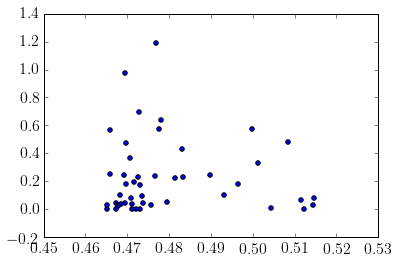

In [49]:
invariant_uncertainty_estimate = 0.455
combined_uncertainty_estimate = np.sqrt(
    variant_uncertainty_estimate**2 + invariant_uncertainty_estimate**2)

plt.scatter(combined_uncertainty_estimate, percent_prediction_differences**2)

In [50]:
np.std(percent_prediction_differences / combined_uncertainty_estimate, ddof=1) / c4(len(percent_prediction_differences))

1.0097354039412256

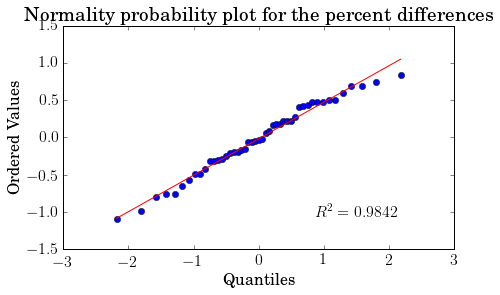

In [54]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(percent_prediction_differences, plot=ax);

ax.set_title("Normality probability plot for the percent differences")

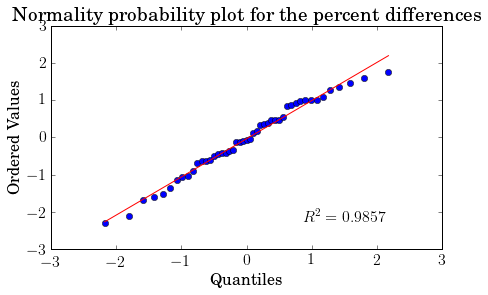

In [55]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(percent_prediction_differences / combined_uncertainty_estimate, plot=ax);

ax.set_title("Normality probability plot for the percent differences")